In [1]:
import os
import torch
import cv2
import numpy as np
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
BASE_CHANNELS = 128  
IMG_SIZE = 256
BATCH_SIZE = 8
LATENT_DIM = 256
# Residual Block for Generator (StyleGAN-inspired)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(channels, channels, 3, padding=1)),
            nn.BatchNorm2d(channels)
        )
        
    def forward(self, x):
        return F.leaky_relu(x + self.conv(x), 0.2)

# Enhanced Generator with Residual Connections
class MedicalGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.init_size = IMG_SIZE // 32
        self.fc = nn.Sequential(
            spectral_norm(nn.Linear(LATENT_DIM + 1, BASE_CHANNELS * 32 * self.init_size ** 2)),
            nn.BatchNorm1d(BASE_CHANNELS * 32 * self.init_size ** 2),
            nn.LeakyReLU(0.2)
        )
        
        self.blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS*32, BASE_CHANNELS*16, 3, padding=1)),
            nn.BatchNorm2d(BASE_CHANNELS*16),
            nn.LeakyReLU(0.2),
            ResidualBlock(BASE_CHANNELS*16),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS*16, BASE_CHANNELS*8, 3, padding=1)),
            nn.BatchNorm2d(BASE_CHANNELS*8),
            nn.LeakyReLU(0.2),
            ResidualBlock(BASE_CHANNELS*8),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS*8, BASE_CHANNELS*4, 3, padding=1)),
            nn.BatchNorm2d(BASE_CHANNELS*4),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS*4, BASE_CHANNELS*2, 3, padding=1)),
            nn.BatchNorm2d(BASE_CHANNELS*2),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS*2, BASE_CHANNELS, 3, padding=1)),
            nn.BatchNorm2d(BASE_CHANNELS),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(BASE_CHANNELS, 1, 3, padding=1)),
            nn.Tanh()
        )

    def forward(self, z, labels):
        labels = labels.view(-1, 1)
        z = torch.cat([z, labels], 1)
        x = self.fc(z).view(-1, BASE_CHANNELS*32, self.init_size, self.init_size)
        return self.blocks(x)
# Load the trained GAN model
class GeneratorWrapper:
    def __init__(self, generator, latent_dim, device):
        self.generator = generator.to(device)
        self.generator.eval()
        self.latent_dim = latent_dim
        self.device = device
    
    def generate_images(self, label, num_images=50, save_dir="generated_images_1_4"):
        os.makedirs(f"{save_dir}/{label}", exist_ok=True)
        
        with torch.no_grad():
            z = torch.randn(num_images, self.latent_dim, device=self.device)
            labels = torch.full((num_images,), label, dtype=torch.float32, device=self.device)
            generated_imgs = self.generator(z, labels)
            
            for i in range(num_images):
                img = generated_imgs[i].cpu().squeeze().numpy()
                img = (img + 1) * 127.5  # Convert from [-1,1] to [0,255]
                img = img.astype(np.uint8)
                
                save_path = f"{save_dir}/{label}/generated3_{i}.png"
                cv2.imwrite(save_path, img)
                print(f"Saved {save_path}")

# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 256  # Ensure this matches your model

generator = MedicalGenerator().to(device)
checkpoint = torch.load("gan_final_1.pth", map_location=device,weights_only=False)
generator.load_state_dict(checkpoint['generator'])

# Generate and save images
gan_wrapper = GeneratorWrapper(generator, latent_dim, device)
for label in [0, 1]:
    gan_wrapper.generate_images(label, num_images=50)


Saved generated_images_1_4/0/generated3_0.png
Saved generated_images_1_4/0/generated3_1.png
Saved generated_images_1_4/0/generated3_2.png
Saved generated_images_1_4/0/generated3_3.png
Saved generated_images_1_4/0/generated3_4.png
Saved generated_images_1_4/0/generated3_5.png
Saved generated_images_1_4/0/generated3_6.png
Saved generated_images_1_4/0/generated3_7.png
Saved generated_images_1_4/0/generated3_8.png
Saved generated_images_1_4/0/generated3_9.png
Saved generated_images_1_4/0/generated3_10.png
Saved generated_images_1_4/0/generated3_11.png
Saved generated_images_1_4/0/generated3_12.png
Saved generated_images_1_4/0/generated3_13.png
Saved generated_images_1_4/0/generated3_14.png
Saved generated_images_1_4/0/generated3_15.png
Saved generated_images_1_4/0/generated3_16.png
Saved generated_images_1_4/0/generated3_17.png
Saved generated_images_1_4/0/generated3_18.png
Saved generated_images_1_4/0/generated3_19.png
Saved generated_images_1_4/0/generated3_20.png
Saved generated_images_

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from natsort import natsorted

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.final(d2)

# Load model
model = ImprovedUNet().to(device)
model.load_state_dict(torch.load("best_model_seg.pth", map_location=device))
model.eval()

IMG_SIZE = (256, 256)
INPUT_FOLDER = "generated_images_1_4"
OUTPUT_FOLDER = "segmented_images_2_3"

def preprocess_image(img):
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32) / 255.0
    return torch.tensor(img).unsqueeze(0).unsqueeze(0).to(device)

# Main loop
for label in ["0", "1"]:
    input_dir = os.path.join(INPUT_FOLDER, label)
    raw_output_dir = os.path.join(OUTPUT_FOLDER, label, "raw")
    mask_output_dir = os.path.join(OUTPUT_FOLDER, label, "mask")
    
    os.makedirs(raw_output_dir, exist_ok=True)
    os.makedirs(mask_output_dir, exist_ok=True)

    for file in natsorted(os.listdir(input_dir)):
        input_path = os.path.join(input_dir, file)
        
        try:
            img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError(f"Failed to read image: {input_path}")
            
            input_tensor = preprocess_image(img)
            with torch.no_grad():
                output = model(input_tensor)
                mask = (output.squeeze().cpu().numpy() > 0.6).astype(np.uint8) * 255

            # Skip saving if the mask is completely black
            if np.count_nonzero(mask) == 0:
                print(f"Skipped (empty mask): {input_path}")
                continue

            base_name = os.path.splitext(file)[0]
            raw_path = os.path.join(raw_output_dir, f"{base_name}_raw.png")
            mask_path = os.path.join(mask_output_dir, f"{base_name}_mask.png")
            
            cv2.imwrite(raw_path, cv2.resize(img, IMG_SIZE))
            cv2.imwrite(mask_path, mask)

            print(f"Saved: {raw_path}, {mask_path}")
        
        except Exception as e:
            print(f"Error processing {input_path}: {str(e)}")

print("Segmentation completed!")


Skipped (empty mask): generated_images_1_4\0\generated3_0.png
Saved: segmented_images_2_3\0\raw\generated3_1_raw.png, segmented_images_2_3\0\mask\generated3_1_mask.png
Saved: segmented_images_2_3\0\raw\generated3_2_raw.png, segmented_images_2_3\0\mask\generated3_2_mask.png
Skipped (empty mask): generated_images_1_4\0\generated3_3.png
Skipped (empty mask): generated_images_1_4\0\generated3_4.png
Skipped (empty mask): generated_images_1_4\0\generated3_5.png
Skipped (empty mask): generated_images_1_4\0\generated3_6.png
Saved: segmented_images_2_3\0\raw\generated3_7_raw.png, segmented_images_2_3\0\mask\generated3_7_mask.png
Skipped (empty mask): generated_images_1_4\0\generated3_8.png
Saved: segmented_images_2_3\0\raw\generated3_9_raw.png, segmented_images_2_3\0\mask\generated3_9_mask.png
Skipped (empty mask): generated_images_1_4\0\generated3_10.png
Skipped (empty mask): generated_images_1_4\0\generated3_11.png
Skipped (empty mask): generated_images_1_4\0\generated3_12.png
Skipped (empty 

In [3]:
import os

OUTPUT_FOLDER = "segmented_images_2_3"

def count_saved_images(label):
    raw_dir = os.path.join(OUTPUT_FOLDER, label, "raw")
    mask_dir = os.path.join(OUTPUT_FOLDER, label, "mask")
    
    raw_count = len([f for f in os.listdir(raw_dir) if f.endswith(".png")])
    mask_count = len([f for f in os.listdir(mask_dir) if f.endswith(".png")])
    
    return raw_count, mask_count

total_raw = 0
total_mask = 0

for label in ["0", "1"]:
    raw_count, mask_count = count_saved_images(label)
    total_raw += raw_count
    total_mask += mask_count
    print(f"Label {label} - Raw images: {raw_count}, Mask images: {mask_count}")

print(f"\nTotal Raw images: {total_raw}, Total Mask images: {total_mask}")


Label 0 - Raw images: 111, Mask images: 111
Label 1 - Raw images: 118, Mask images: 118

Total Raw images: 229, Total Mask images: 229


Setting up directory structure...
Created directories for label 0:
 - Raw directory: d:\gankushagra\new-20241107T124416Z-001\cnn\segmented_images_2_3\0\raw
 - Mask directory: d:\gankushagra\new-20241107T124416Z-001\cnn\segmented_images_2_3\0\mask
Created directories for label 1:
 - Raw directory: d:\gankushagra\new-20241107T124416Z-001\cnn\segmented_images_2_3\1\raw
 - Mask directory: d:\gankushagra\new-20241107T124416Z-001\cnn\segmented_images_2_3\1\mask
Directory setup complete. Please add your images to these directories.
Counting images per label:
Label 0: 111 raw images, 111 masks
Label 1: 118 raw images, 118 masks
Processing images from segmented_images_2_3\0\raw
Found 111 raw images and 111 masks for label 0
Processing images from segmented_images_2_3\1\raw
Found 118 raw images and 118 masks for label 1

Total dataset samples: 229


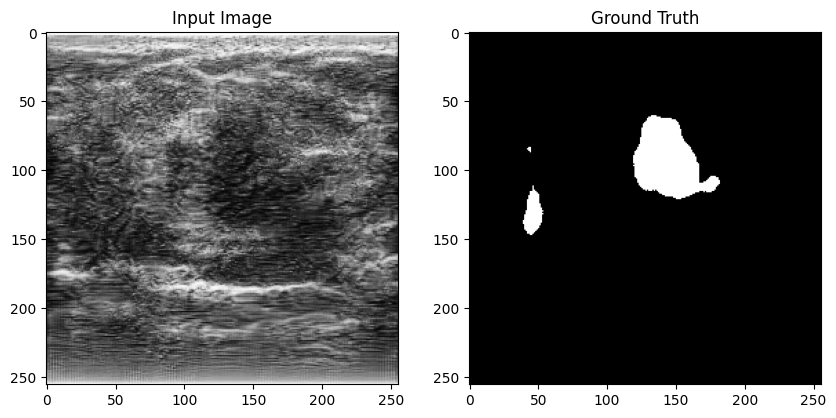

Training on device: cuda
Training samples: 183, Validation samples: 46

Epoch 1/100
Train Loss: 0.5111 | Acc: 0.9245 | Dice: 0.0428 | IoU: 0.0219
Val   Loss: 0.4907 | Acc: 0.9816 | Dice: 0.0000 | IoU: 0.0000

Epoch 2/100
Train Loss: 0.3497 | Acc: 0.9781 | Dice: 0.0000 | IoU: 0.0000
Val   Loss: 0.3143 | Acc: 0.9810 | Dice: 0.0000 | IoU: 0.0000

Epoch 3/100
Train Loss: 0.2970 | Acc: 0.9796 | Dice: 0.0015 | IoU: 0.0008
Val   Loss: 0.2833 | Acc: 0.9813 | Dice: 0.0192 | IoU: 0.0097
Saved new best model with Dice: 0.0192

Epoch 4/100
Train Loss: 0.2726 | Acc: 0.9808 | Dice: 0.1332 | IoU: 0.0714
Val   Loss: 0.2709 | Acc: 0.9829 | Dice: 0.4470 | IoU: 0.2879
Saved new best model with Dice: 0.4470

Epoch 5/100
Train Loss: 0.2540 | Acc: 0.9824 | Dice: 0.3888 | IoU: 0.2413
Val   Loss: 0.2809 | Acc: 0.9747 | Dice: 0.5293 | IoU: 0.3599
Saved new best model with Dice: 0.5293

Epoch 6/100
Train Loss: 0.2378 | Acc: 0.9837 | Dice: 0.5533 | IoU: 0.3825
Val   Loss: 0.2384 | Acc: 0.9844 | Dice: 0.3306 | Io

In [4]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from natsort import natsorted
import matplotlib.pyplot as plt

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100
VAL_SPLIT = 0.2
# Fix typo in directory name (if needed) and use normalized path
DATA_PATH = "segmented_images_2_3"  # Remove trailing slash and fix spelling
LABELS = ["0", "1"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset Class
class UltrasoundDataset(Dataset):
    def __init__(self, data_path):
        self.rf_images = []
        self.roi_masks = []
        valid_extensions = ('.png', '.jpg', '.jpeg')

        for label in LABELS:
            # Updated path handling to be more robust
            rf_path = os.path.join(data_path, label, "raw")
            roi_path = os.path.join(data_path, label, "mask")
            
            # Check if directories exist
            if not os.path.exists(rf_path):
                print(f"Warning: Raw directory not found: {os.path.abspath(rf_path)}")
                continue
                
            if not os.path.exists(roi_path):
                print(f"Warning: Mask directory not found: {os.path.abspath(roi_path)}")
                continue
            
            print(f"Processing images from {rf_path}")
            
            rf_files = natsorted([f for f in os.listdir(rf_path) if f.lower().endswith(valid_extensions)])
            roi_files = natsorted([f for f in os.listdir(roi_path) if f.lower().endswith(valid_extensions)])

            if len(rf_files) == 0:
                print(f"Warning: No valid images found in {rf_path}")
                
            if len(roi_files) == 0:
                print(f"Warning: No valid masks found in {roi_path}")
                
            print(f"Found {len(rf_files)} raw images and {len(roi_files)} masks for label {label}")
            
            # Make sure we only process files that have both image and mask
            for rf_file, roi_file in zip(rf_files, roi_files):
                rf_path_full = os.path.join(rf_path, rf_file)
                roi_path_full = os.path.join(roi_path, roi_file)
                
                rf_img = cv2.imread(rf_path_full, cv2.IMREAD_GRAYSCALE)
                roi_img = cv2.imread(roi_path_full, cv2.IMREAD_GRAYSCALE)

                if rf_img is None:
                    print(f"Warning: Could not read image: {rf_path_full}")
                    continue
                    
                if roi_img is None:
                    print(f"Warning: Could not read mask: {roi_path_full}")
                    continue

                rf_img = cv2.resize(rf_img, IMG_SIZE)
                roi_img = cv2.resize(roi_img, IMG_SIZE)
                roi_img = (roi_img > 127).astype(np.float32)

                # Data augmentation
                if np.random.rand() > 0.5:
                    rf_img = cv2.flip(rf_img, 1)
                    roi_img = cv2.flip(roi_img, 1)

                if np.random.rand() > 0.5:
                    angle = np.random.randint(-15, 15)
                    M = cv2.getRotationMatrix2D((IMG_SIZE[0]//2, IMG_SIZE[1]//2), angle, 1)
                    rf_img = cv2.warpAffine(rf_img, M, IMG_SIZE)
                    roi_img = cv2.warpAffine(roi_img, M, IMG_SIZE)

                self.rf_images.append(rf_img)
                self.roi_masks.append(roi_img)

    def __len__(self):
        return len(self.rf_images)

    def __getitem__(self, idx):
        img = torch.tensor(self.rf_images[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        mask = torch.tensor(self.roi_masks[idx], dtype=torch.float32).unsqueeze(0)
        return img, mask

# Improved U-Net model (unchanged)
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.pool = nn.MaxPool2d(2)
        
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.final(d2)

# Metrics (unchanged)
def calculate_metrics(TP, TN, FP, FN):
    eps = 1e-10
    return {
        'Accuracy': (TP + TN) / (TP + TN + FP + FN + eps),
        'Recall': TP / (TP + FN + eps),
        'Specificity': TN / (TN + FP + eps),
        'Precision': TP / (TP + FP + eps),
        'Dice': (2 * TP) / (2 * TP + FP + FN + eps),
        'IoU': TP / (TP + FP + FN + eps)
    }

# Count Images in Each Label - improved error handling
def count_images_per_label():
    print("Counting images per label:")
    for label in LABELS:
        raw_dir = os.path.join(DATA_PATH, label, "raw")
        mask_dir = os.path.join(DATA_PATH, label, "mask")

        if not os.path.exists(raw_dir) or not os.path.exists(mask_dir):
            print(f"Directory missing for label {label}:")
            print(f" - Raw path exists? {os.path.exists(raw_dir)} -> {os.path.abspath(raw_dir)}")
            print(f" - Mask path exists? {os.path.exists(mask_dir)} -> {os.path.abspath(mask_dir)}")
            continue

        raw_count = len([f for f in os.listdir(raw_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        mask_count = len([f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        
        print(f"Label {label}: {raw_count} raw images, {mask_count} masks")

# Function to verify and create directory structure
def setup_directories():
    print("Setting up directory structure...")
    for label in LABELS:
        raw_dir = os.path.join(DATA_PATH, label, "raw")
        mask_dir = os.path.join(DATA_PATH, label, "mask")
        
        # Create directories if they don't exist
        os.makedirs(raw_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)
        
        print(f"Created directories for label {label}:")
        print(f" - Raw directory: {os.path.abspath(raw_dir)}")
        print(f" - Mask directory: {os.path.abspath(mask_dir)}")
    
    print("Directory setup complete. Please add your images to these directories.")

def train_model():
    # Check if we have any data
    has_data = False
    for label in LABELS:
        raw_dir = os.path.join(DATA_PATH, label, "raw")
        if os.path.exists(raw_dir) and len(os.listdir(raw_dir)) > 0:
            has_data = True
            break
    
    if not has_data:
        print("No data found. Please add images to your dataset directories.")
        return
        
    dataset = UltrasoundDataset(DATA_PATH)
    
    if len(dataset) == 0:
        print("Dataset is empty. Please check your image directories and file formats.")
        return
        
    print(f"\nTotal dataset samples: {len(dataset)}")
    
    # Show a sample from the dataset
    sample_img, sample_mask = dataset[0]
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(122)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.show()

    # Split dataset into training and validation
    train_size = int((1 - VAL_SPLIT) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # Initialize model, optimizer, scheduler, and loss function
    model = ImprovedUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    criterion = nn.BCELoss()
    best_dice = 0

    print(f"Training on device: {device}")
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        train_TP = train_TN = train_FP = train_FN = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            with torch.no_grad():
                preds = (outputs > 0.5).float()
                TP = (preds * masks).sum().item()
                TN = ((1 - preds) * (1 - masks)).sum().item()
                FP = (preds * (1 - masks)).sum().item()
                FN = ((1 - preds) * masks).sum().item()
                train_TP += TP
                train_TN += TN
                train_FP += FP
                train_FN += FN

        model.eval()
        val_loss = 0
        val_TP = val_TN = val_FP = val_FN = 0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()

                preds = (outputs > 0.5).float()
                TP = (preds * masks).sum().item()
                TN = ((1 - preds) * (1 - masks)).sum().item()
                FP = (preds * (1 - masks)).sum().item()
                FN = ((1 - preds) * masks).sum().item()
                val_TP += TP
                val_TN += TN
                val_FP += FP
                val_FN += FN

        train_metrics = calculate_metrics(train_TP, train_TN, train_FP, train_FN)
        val_metrics = calculate_metrics(val_TP, val_TN, val_FP, val_FN)
        scheduler.step(val_loss)

        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | Acc: {train_metrics['Accuracy']:.4f} | Dice: {train_metrics['Dice']:.4f} | IoU: {train_metrics['IoU']:.4f}")
        print(f"Val   Loss: {val_loss/len(val_loader):.4f} | Acc: {val_metrics['Accuracy']:.4f} | Dice: {val_metrics['Dice']:.4f} | IoU: {val_metrics['IoU']:.4f}")

        if val_metrics['Dice'] > best_dice:
            best_dice = val_metrics['Dice']
            torch.save(model.state_dict(), "best_model_seg_NEW_2.pth")
            print(f"Saved new best model with Dice: {best_dice:.4f}")

if __name__ == "__main__":
    # Create the directory structure if needed
    setup_directories()
    
    # Check if images are properly placed
    count_images_per_label()
    
    # Ask user if they want to proceed with training
    proceed = input("Do you want to proceed with training? (y/n): ")
    if proceed.lower() in ['y', 'yes']:
        train_model()
    else:
        print("Training cancelled. Please add images to the directories and run again.")